In [3]:
import sys
import numpy as np
import scipy.interpolate as si
import os
import scipy.optimize
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, expanduser
#import geo_3 as geometry
#print(os.path.expanduser('~')) 
home = os.path.expanduser('~')

sys.path.append(join(home,'github/helpfullscripts/'))
sys.path.append(join(home,'Projects/helpfullscripts/'))
import forJCM

import jcm_plotting_utils as JCMgrid

#jcm_root = join(home,'JCMwave/JCMsuite_6_2_1/ThirdPartySupport/Python')
jcm_root = join(home,'JCMwave/JCMsuite_6_4_8/ThirdPartySupport/Python')
sys.path.append(jcm_root)
import jcmwave




sys.path.append(join(home,'github/XRR_workflows/calculate_n_k_from_xrr'))
sys.path.append(join(home,'Projects/XRR_workflows/calculate_n_k_from_xrr'))
import xray_compounds as xc
import pint
unit = pint.UnitRegistry()

#import pythia.Misc as MISC

#from paramiko import SSHClient

#import json

import pandas as pd

import pickle 

#import xraylib

import time

import matplotlib as mpl
import matrixmethod as mm
mpl.rcParams['font.family'] = ['sans']
mpl.rcParams['font.serif'] = ['DejaVu Sans']

In [49]:
jcmwave.daemon.shutdown()
jcmwave.daemon.add_workstation(
    Hostname="localhost",
    # Login='andrle01',
    Multiplicity=3,
    NThreads=12,
)

[1884861347, 982866512, 247169396]

In [65]:
class Shape:
    def __init__(self, name, domain_id, priority, side_length_constraint, points,nk):
        self.name = name
        self.domain_id = domain_id
        self.priority = priority
        self.side_length_constraint = side_length_constraint
        self.points = points
        self.nk = nk

        self.permittivity = np.square(self.nk)

    def describe(self):
        return f"""Shape: {self.name}
  Domain ID: {self.domain_id}
  Priority: {self.priority}
  Side Length Constraint: {self.side_length_constraint}
  Refractive Index (nk): {self.nk}
  Permittivity (ε): {self.permittivity}
"""
    def plot(self, ax=None, **kwargs):
        x = self.points[::2]
        y = self.points[1::2]
        x = np.append(x, x[0])  # Close the polygon
        y = np.append(y, y[0])
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_aspect('equal')
            ax.set_title(f"Shape: {self.name}")
            ax.legend()
            
            ax.plot(x, y, label=self.name, **kwargs)
            return fig
        else:
            ax.plot(x, y, label=self.name, **kwargs)
            return ax





In [67]:
thick = np.array([20,35,1.2] )
rough = np.array([0,0,0,0] )
wl = [13.5]
ang_deg = np.array([90])#np.linspace(0.1, 2.0, 10001)
ang = np.deg2rad(ang_deg)
nk_TOK = [1-0.023+0.00419j]
nk_Chaucer = [1-0.0226+0.0048j]
nk_SOG = [1-0.0195-0.006j]
nk_sub = np.conjugate(xc.refractive_index('Si',wl* unit.nm,density=2.33))
nk_sub_oxid = np.conjugate(xc.refractive_index('SiO2',wl* unit.nm,density=2.0929729034348785))

thick_noUL = np.array([20,1.2] )
rough_noUL = np.array([0,0,0] )
keys = {'uol1': 1e-9,
        'fem_deg': 4,}

#keys['energy'] = energy[i_taken_energy].to(unit.keV, 'sp').magnitude
#print(keys['energy'])
keys['pol'] = [1, 0] #1,0 s pol 0,1 p pol
keys['lamb'] = wl[0] * 1e-9
keys['slc'] = 1
slc=1
keys['nk'] = [ 1 + 0 * 1j, #vacuum
              nk_TOK, #nk_Si3N4, #layer on top of the substrate
              nk_SOG, #material of the grating
            nk_sub_oxid, #Background
              nk_sub, #surface_matt
             ]
keys['name_domain'] = ['vacuum','resist','UL','oxide','substrate']

pitch = 2
p2 = pitch /2
substrate_offset = 30
vacuum_offset = 30
y = np.sum(thick)

keys['points_cd'] = np.array([-p2,-substrate_offset,p2,-substrate_offset,p2,y+vacuum_offset,-p2,y+vacuum_offset])
keys['points_substrate'] = np.array([-p2,-substrate_offset,p2,-substrate_offset,p2,0,-p2,0])
keys['points_substrate_oxide'] = np.array([-p2,0,p2,0,p2,thick[-1],-p2,thick[-1]])
keys['points_UL'] = np.array([-p2,thick[-1],p2,thick[-1],p2,np.sum(thick[-2:]),-p2,np.sum(thick[-2:])])
keys['points_resist'] = np.array([-p2,np.sum(thick[-2:]),p2,np.sum(thick[-2:]),p2,y,-p2,y])

shape = [
    Shape('ComputationalDomain',domain_id = 1,priority=-1,side_length_constraint=slc,points=keys['points_cd'], nk = 1 ),
    Shape('substrate',domain_id = 2,priority=1,side_length_constraint=slc,points=keys['points_substrate'], nk = nk_sub ),
    Shape('substrate_oxide',domain_id = 3,priority=2,side_length_constraint=slc,points=keys['points_substrate_oxide'], nk = nk_sub_oxid ),
    Shape('UL',domain_id = 4,priority=2,side_length_constraint=slc,points=keys['points_UL'], nk = nk_SOG ),
    Shape('resist',domain_id = 5,priority=2,side_length_constraint=slc,points=keys['points_resist'], nk = nk_TOK ),
]
shape[0].domain_id
keys['shape']=shape
keys['energy_index'] = 0

In [61]:
print(shape[0].describe())

Shape: ComputationalDomain
  Domain ID: 1
  Priority: -1
  Side Length Constraint: 1
  Refractive Index (nk): 1
  Permittivity (ε): 1



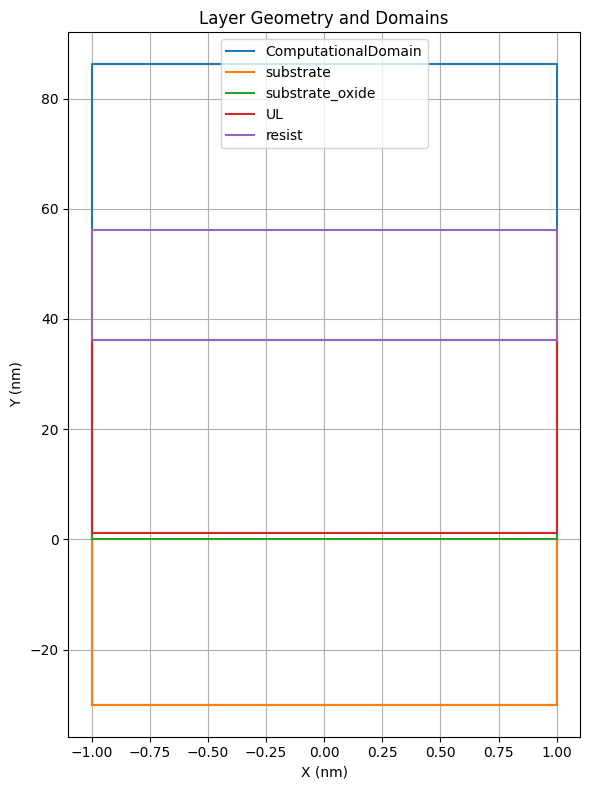

In [68]:
import matplotlib.pyplot as plt

# Create a shared figure and axis
fig, ax = plt.subplots(figsize=(6, 8))

# Plot each shape
for s in shape:
    s.plot(ax=ax)

# Final touches
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_title("Layer Geometry and Domains")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [48]:
jcmwave.geo("../JCM_clean/",keys=keys)

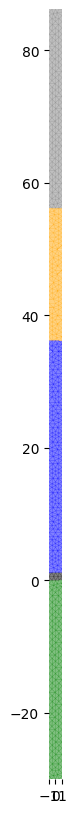

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))

JCMgrid.plot_grid(
    "../JCM_clean/grid.jcm",
    ax=ax,
    colors={1: "grey", 2: "green", 3: "black", 4: "blue", 5: "orange", 6: "pink"},
    alpha=0.5,
    lw=0.2,
)
ax.set_xlim(-p2, p2)
ax.set_ylim(-substrate_offset, y+vacuum_offset)
ax.set_frame_on(False)
# remove ticks and labels
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_aspect("equal")

In [55]:
ids = []

keys['slc'] = 0.7

keys['phi']=90
keys['angle_of_incidence']= 0 #-82 #87.285796
#results = jcmwave.solve("./BlazedGrating/JCM_clean/project.jcmpt",keys=keys)
ids.append(
    jcmwave.solve('../JCM_clean/project-field.jcmpt',  keys=keys, temporary=True)
)
#results = [results]

results, logs = jcmwave.daemon.wait(ids, verbose=False)

In [56]:
logs

[{'ExitCode': 0,
  'Log': {'Error': '',
   'Out': '\n\n\n*** Solving /tmp/__JCMwave__8uy5snbg/project-field.jcmp on refinement level 0 ... \n  *** A priori interior domain wave propagation characteristics (vacuum wavelength = 13.500 nm):\n  \n       Compartment "Y":\n    computational domain size:  8.6 (wavelengths).\n    computational domain range wave propagation error: 7.1e-07\n    \'one wavelength\' wave propagation error: 2.4e-07 \n  \n       Compartment "-Y":\n    computational domain size:  8.6 (wavelengths).\n    computational domain range wave propagation error: 6.7e-07\n    \'one wavelength\' wave propagation error: 2.4e-07 \n\nCell percentage per Finite Element degree\n  FEM degree  Cell percentage\n-----------------------------------------\n           4            100.0\n\nassembling problem (43136 unknowns) ...  \nassembling problem done: 00:00:00.65 (cpu), 00:00:00.07 (total) (matrix entries/row = 22)\nsolving discrete problem ... \nMemory requirement estimated by the lin